In [10]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [11]:
#load MNIST dataset
(x_train,_),(x_test,y_test)= tf.keras.datasets.mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0
x_train=np.reshape(x_train,(-1,28,28,1))
x_test=np.reshape(x_train,(-1,28,28,1))
LATENT_DIM=2



In [12]:
#sampling layer for the reparameterization trick
class Sampling(layers.Layer):
  def call(self,inputs):
    z_mean,z_log_var=inputs
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean+tf.exp(0.5*z_log_var)*epsilon

In [13]:
#ENCODER MODEL
def build_encoder():
  encoder_inputs= tf.keras.Input(shape=(28,28,1))
  x = layers.Conv2D(32,3,activation='relu',strides=2,padding='same')(encoder_inputs)
  x=layers.Conv2D(64,3,activation='relu',strides=2,padding='same')(x)
  x=layers.Flatten()(x)
  x=layers.Dense(16,activation='relu')(x)
  z_mean=layers.Dense(LATENT_DIM,name="z_mean")(x)
  z_log_var=layers.Dense(LATENT_DIM,name="z_log_var")(x)
  z=Sampling()([z_mean,z_log_var])
  return tf.keras.Model(encoder_inputs,[z_mean,z_log_var,z],name="encoder")


In [14]:
#decoder Model
def build_decoder():
  latent_inputs=tf.keras.Input(shape=(LATENT_DIM,))
  x=layers.Dense(7*7*64,activation='relu')(latent_inputs)
  x=layers.Reshape((7,7,64))(x)
  x=layers.Conv2DTranspose(64,3,strides=2,activation='relu',padding='same')(x)
  x=layers.Conv2DTranspose(32,3,strides=2,activation='relu',padding='same')(x)
  decoder_outputs=layers.Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)
  return tf.keras.Model(latent_inputs,decoder_outputs,name="decoder")


In [15]:
#construct the VAE model and define the loss
class VAE(tf.keras.Model):
  def __init__(self,encoder,decoder):
    super(VAE,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
  def compile(self,optimizer):
    super(VAE,self).compile()
    self.optimizer = optimizer
    self.total_loss_tracker=tf.keras.metrics.Mean(name="total=loss")
  def train_step(self,data):
    if isinstance(data,tuple):
      data=data[0]
    with tf.GradientTape() as tape:
      z_mean,z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss=tf.reduce_mean(tf.keras.losses.binary_crossentropy(data,reconstruction))
      reconstruction_loss *=28*28
      kl_loss= -0.5*tf.reduce_mean(1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var))
      total_loss= reconstruction_loss +kl_loss
      grads= tape.gradient(total_loss,self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      return {"loss":self.total_loss_tracker.result()}


In [16]:
#training the dataset
encoder=build_encoder()
decoder=build_decoder()
vae=VAE(encoder,decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train,epochs=10,batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 109ms/step - loss: 257.6820
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 105ms/step - loss: 178.0619
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - loss: 163.3226
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - loss: 158.0463
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - loss: 155.6249
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - loss: 154.0991
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - loss: 152.6853
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - loss: 151.6684
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - loss: 151.4895
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - loss: 150.3015


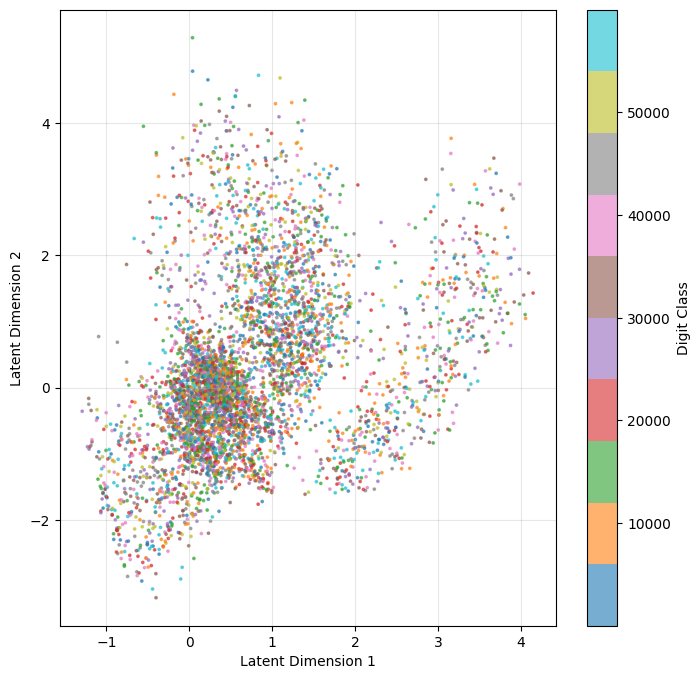

In [19]:
#visualization of latent space
def plot_latent_space (vae,data,labels,n_samples=5000):
  indices= np.random.choice(len(data),n_samples,replace=False)
  data_subset=data[indices]
  label_subset=[indices]
  #encode data to latent space
  z_mean,z_log_var,z=vae.encoder(data_subset)
  z_mean_np=z_mean.numpy()
  #scatter plot
  plt.figure(figsize=(8,8))
  scatter=plt.scatter(z_mean_np[:,0],z_mean_np[:,1],c=label_subset,cmap='tab10',alpha=0.6,s=3)
  plt.colorbar(scatter,label='Digit Class')
  plt.xlabel('Latent Dimension 1')
  plt.ylabel('Latent Dimension 2')
  plt.grid(True,alpha=0.3)
  plt.show()

plot_latent_space(vae,x_test,y_test)


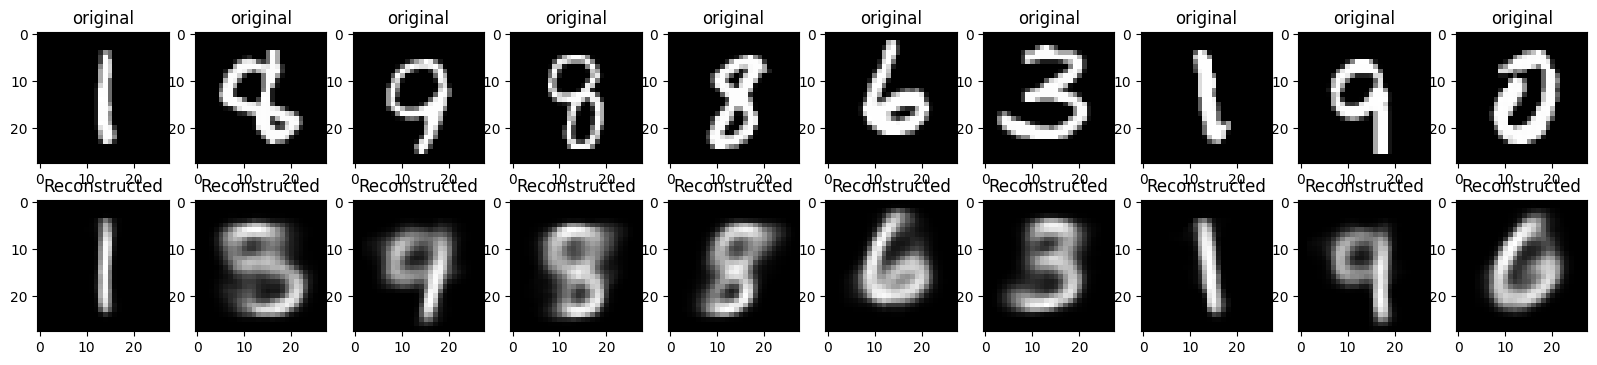

In [18]:
def plot_reconstruction_comparison (vae, data, n_samples=10):
    indices = np.random.choice (len(data), n_samples, replace=False)
    original_images=data[indices]
    z_mean, z_log_var, z = vae.encoder (original_images)
    reconstructed_images = vae.decoder (z)
    plt.figure (figsize=(20,4))
    for i in range (n_samples):
        plt.subplot(2,n_samples, i+1)
        plt.imshow(original_images[i].reshape(28,28), cmap='gray')
        plt.title('original')


        plt.subplot(2,n_samples, i+1+n_samples)
        plt.imshow(reconstructed_images[i].numpy().reshape(28,28), cmap='gray')
        plt.title('Reconstructed')
    plt.show()

plot_reconstruction_comparison(vae,x_test)